# Image Captions Generation

### Introduction
In this final project I will create and evaluate a model that gernerates captions for images. To do this I will need to use CNN's, text transformers, and image augmentation. This will be a very challenging project and I will on a multitude of resources to help me. I will be using the data source Flickr8K which has arround 8000 images with captions that we will be able to use our supervised learning aproach on. I will also so use Bilingual evaluation understudy (BLEU) to evalute the prefomance of the model. Using BLEU is important for evaluation because it can give us benchmarks against to compare to.


### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

The first step in eda is downloading the data in an eviorment we can work in. For this project I will be doing most of the work in Google Colab as it allows for easier use of cloud computing often for free if the project is small enough. I hope to keep it with in those requirements.

This is how we download the data to the container that the Google colab notebook runs on:



In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

We now need to set up variables to more easily reference the image data and scale it to an apropriate size. And pull that data into a structure we can use. I will then display some examples images and one of the captions for the images.

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

In [ ]:

img_path = "Flicker8k_Dataset" # Path to the images
img_size = (299, 299) # Image Scaling
seq_len = 25

def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(img_path, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > seq_len:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

def show_image(image):
  img = mpimg.imread(image)
  new_size = img_size
  img_pil = Image.fromarray(img)  # Create a new image object
  img_pil = img_pil.resize(new_size)  # Resize the image
  img = np.array(img_pil)  # Convert back to a NumPy array
  fig, ax = plt.subplots()

  ax.imshow(img)

  plt.show()



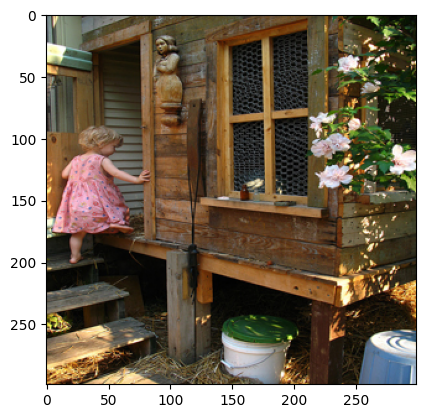

A girl going into a wooden building .


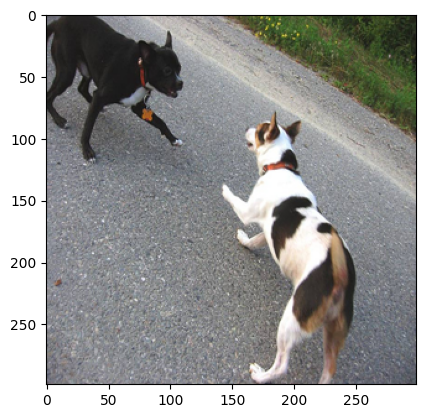

A black dog and a tri-colored dog playing with each other on the road .


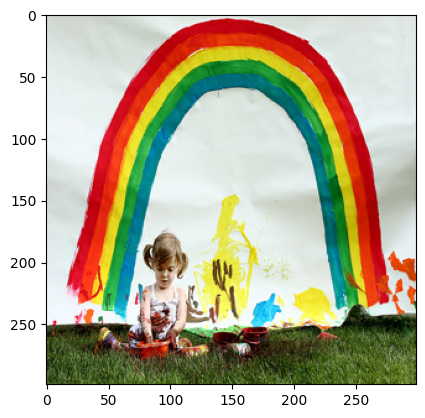

A little girl is sitting in front of a large painted rainbow .


In [ ]:
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

img_demo = list(captions_mapping.keys())[:3]
for x in img_demo:
  show_image(x)
  print(captions_mapping[x][1].replace("<start> ", "").replace(" <end>", "").strip().strip())

While this is quite interesting, before we procede I think we need to dig into the text data more to see if we need to remove anything or if we are to continue forward.

In [ ]:
from collections import Counter
from itertools import chain

In [ ]:
flat_captions = chain.from_iterable(list(captions_mapping.values()))
w = []
for x in flat_captions:
  w = w + x.split()

counts = Counter(w)
print(counts)



Counter({'<start>': 38215, '<end>': 38215, 'a': 38154, '.': 34659, 'A': 21530, 'in': 17972, 'the': 14503, 'on': 10156, 'is': 8862, 'and': 8233, 'dog': 7697, 'with': 7330, 'man': 6407, 'of': 6360, 'Two': 4083, 'white': 3624, 'black': 3473, 'are': 3285, 'boy': 3261, 'girl': 3018, 'woman': 3011, 'to': 2962, ',': 2942, 'The': 2937, 'wearing': 2862, 'at': 2745, 'water': 2679, 'red': 2486, 'brown': 2357, 'people': 2330, 'young': 2294, 'his': 2222, 'blue': 2122, 'through': 1983, 'running': 1968, 'dogs': 1943, 'playing': 1892, 'an': 1857, 'while': 1801, 'down': 1731, 'ball': 1689, 'standing': 1689, 'shirt': 1676, 'grass': 1557, 'little': 1554, 'snow': 1438, 'child': 1417, 'jumping': 1410, 'over': 1357, 'person': 1333, 'sitting': 1302, 'front': 1300, 'holding': 1255, 'field': 1230, 'two': 1190, 'up': 1178, 'by': 1175, 'small': 1170, 'green': 1166, 'yellow': 1149, 'large': 1141, 'walking': 1107, 'group': 1106, 'her': 1091, 'into': 1032, 'beach': 1014, 'Three': 1013, 'air': 993, 'men': 976, 'near

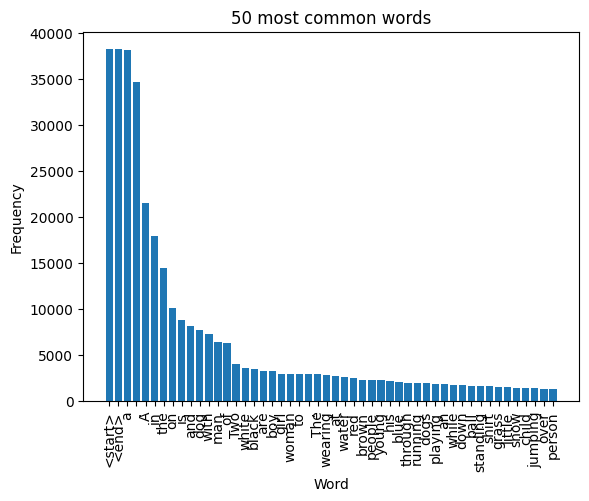

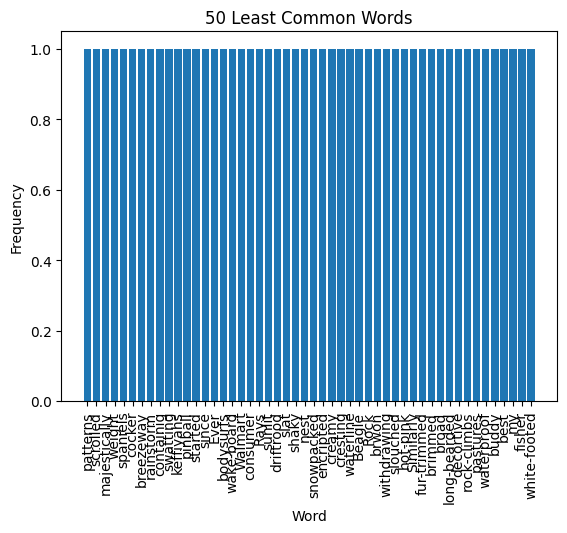

In [ ]:
most_common_words = counts.most_common()[:50] # Top 50 words
least_common_words = counts.most_common()[:-51:-1]
# Create a bar chart of the word frequencies.
plt.bar(range(len(most_common_words)), [word[1] for word in most_common_words])

plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("50 most common words")
plt.xticks(np.arange(50),[word[0] for word in most_common_words],rotation=90,fontsize=10)
plt.show()

plt.bar(range(len(least_common_words)), [word[1] for word in least_common_words])
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("50 Least Common Words")
plt.xticks(np.arange(50),[word[0] for word in least_common_words],rotation=90,fontsize=10)
plt.show()


From these word frequency graphs we see that we need to clean the data in the most frequent graphs we have the some unwanted words and other words that wont be very valuable to training. On the least frequesnt words we see a list of words that probably dont need to be included as they only have a a single instance.

Next we will clean the text data and vectorize it in preperation for training.

In [ ]:
import tensorflow as tf
from keras.layers import TextVectorization
import re

In [ ]:


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vocab_size = 10000
vectorization = TextVectorization(
    max_tokens= vocab_size,
    output_mode="int",
    output_sequence_length=seq_len,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

##### Data Pipeline
Now that we have our data clean we can begin to prepare to train the data. To do this we will first break the data into train and validation sets then create a tensorflow dataset that reads the image from the disk and tokienizes the 5 captions.

Lets start with breaking the data into train and test sets.

In [ ]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [ ]:
batch_size = 64

autotune = tf.data.AUTOTUNE
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(batch_size * 8)
    dataset = dataset.map(process_input, num_parallel_calls=autotune)
    dataset = dataset.batch(batch_size).prefetch(autotune)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


### Modeling

The image captioning architecture consists of three models:


1.   CNN for image processing
2.   TransformerEncoder which creates a new representaion of the CNN's output
3.   TransformerDecoder that takes the TransfomerEncoder and generates the caption


Because we have limited resources I am going to use google's EfficientNetB0 CNN to more accuratly classify the objects in the images. EfficientNetB0 can successfully categorize objects in an image into 1000 categories. As we are just trying to caption images I belive this will give a high base line for us to then add a few more layers that will help us for the motives of this project.




In [ ]:
import keras
from keras import layers
from keras.applications import efficientnet

In [ ]:
#setting Hyperparameters
embed_dim = 512
ff_dim = 512
epochs = 30

#This helps prevent overfiting in images training
img_aug = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


def get_cnn_model(): #uses transfer learning to start the cnn for better image cateogrization
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*img_size, 3),
        include_top=False,
        weights="imagenet",
    )
    #freeze feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        self.layernorm_1 = layers.LayerNormalization()

        self.layernorm_2 = layers.LayerNormalization()

        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training,mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,

        )
        out = self.layernorm_2(inputs + attention_output_1)
        return out


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs,mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=embed_dim,
            sequence_length=seq_len,
            vocab_size=vocab_size,
        )
        self.out = layers.Dense(vocab_size, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioning(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,):


        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)


        img_embed = self.cnn_model(batch_img)

        # pass along captions and calculate metrics
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                batch_loss = batch_loss + loss
                batch_acc =  batch_acc + acc

            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )


            grads = tape.gradient(loss, train_vars)

            self.optimizer.apply_gradients(zip(grads, train_vars))

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # Return metrics
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0


        img_embed = self.cnn_model(batch_img)

        # pass captions and calculate metrics
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            batch_loss = batch_loss + loss
            batch_acc = batch_acc + acc

        batch_acc /= float(self.num_captions_per_image)


        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)


        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoder(embed_dim=embed_dim, dense_dim=ff_dim, num_heads=1)
decoder = TransformerDecoder(embed_dim=embed_dim, ff_dim=ff_dim, num_heads=2)
caption_model = ImageCaptioning(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=img_aug,
)

#### Model Training

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='none',
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(), loss=cross_entropy,metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Fit the model
caption_model_hist = caption_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
96/96 [==============================] - 97s 800ms/step - loss: 13.7037 - acc: 0.4311 - val_loss: 15.9642 - val_acc: 0.3949
Epoch 2/30
96/96 [==============================] - 70s 730ms/step - loss: 13.2971 - acc: 0.4352 - val_loss: 15.9122 - val_acc: 0.3985
Epoch 3/30
96/96 [==============================] - 69s 720ms/step - loss: 12.9536 - acc: 0.4391 - val_loss: 15.9563 - val_acc: 0.3976
Epoch 4/30
96/96 [==============================] - 70s 727ms/step - loss: 12.6573 - acc: 0.4425 - val_loss: 16.0189 - val_acc: 0.3985
Epoch 5/30
96/96 [==============================] - 68s 712ms/step - loss: 12.4793 - acc: 0.4416 - val_loss: 15.9998 - val_acc: 0.3980


### Results

Lets take a look at the results of the training. Even though it wont be super telling lets look at the accuracy and loss.

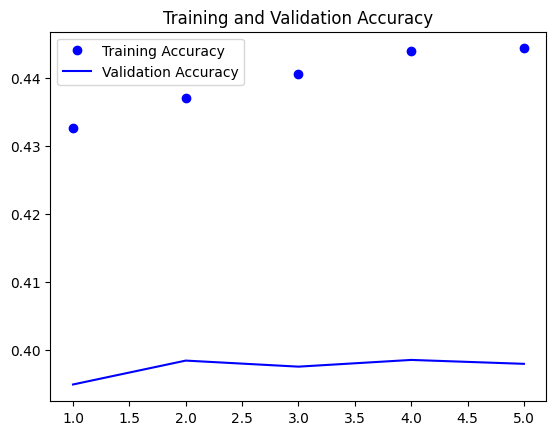

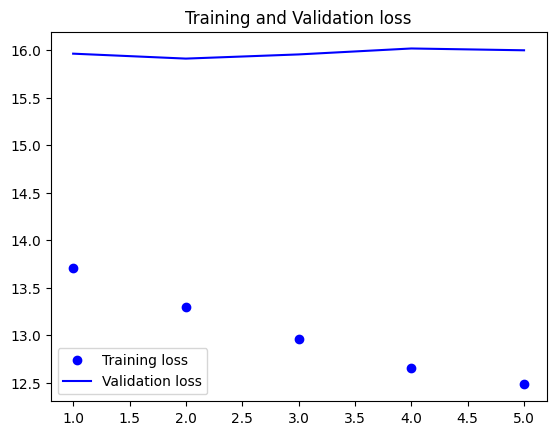

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_model_acc(model_history):
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.figure()

plot_model_acc(caption_model_hist)

The was accuarcy and loss are cacluted can be a little miss leading on how well this model is preforming. It see how many of the words are simmilar from the created captions to the given captions. While that does well for training its not the best way to evaluate if the captions are good.

Lets take a look at the images and some generated captions.

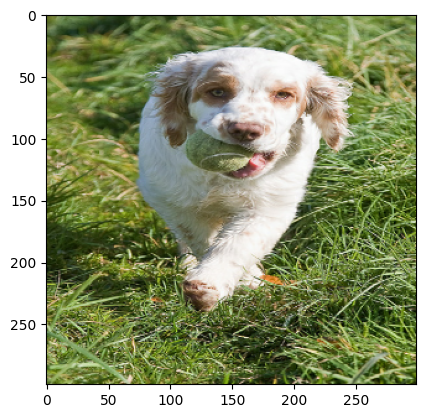

Predicted Caption:  a white dog is running through the grass


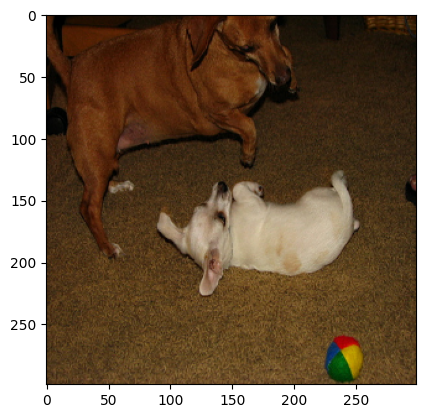

Predicted Caption:  a dog is jumping to catch a ball


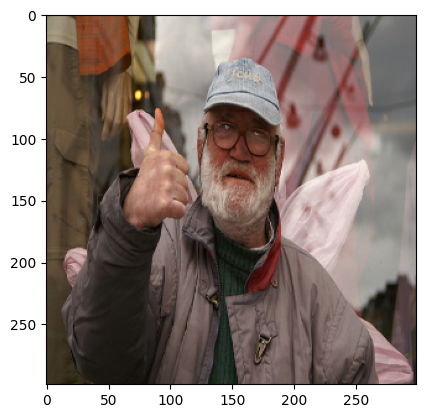

Predicted Caption:  a man wearing a hat and sunglasses is holding a sign


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = seq_len - 1
valid_images = list(valid_data.keys())


def generate_caption_rand():

    sample_img = np.random.choice(valid_images)


    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()


    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)


    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


generate_caption_rand()
generate_caption_rand()
generate_caption_rand()

Seeing these anecdotal results is great but doesnt really tell us how well the model is preforming beyond anecdotal evidence. We should look at ways we can quatify these results. For this I will use Bilingual evaluation understudy (BLEU) which is a way we can quatitify captions accuaracy against human created captions. BLEU is calculated by looking at chuncks of similar words,typicaly between 1 and 4. And then uses a brevity penalty for captions that are too short. This has shown to be a very helpful way to gauge acuracy of language translations and in how humnas interperate information then describe it verbally. The Natrual Languge Toolkit(NLTK) gives us a very convient function to help us evlaute models this way.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# start with generating captions for every validation image
bleu_hyp = []
bleu_ref = []
for i in valid_images:
  n = i
  i = decode_and_resize(i)
  img = i.numpy().clip(0, 255).astype(np.uint8)

  # Pass the image to the CNN
  img = tf.expand_dims(i, 0)
  img = caption_model.cnn_model(img)

  # Pass the image features to the Transformer encoder
  encoded_img = caption_model.encoder(img, training=False)

  # Generate the caption using the Transformer decoder
  decoded_caption = "<start> "
  for i in range(max_decoded_sentence_length):
      tokenized_caption = vectorization([decoded_caption])[:, :-1]
      mask = tf.math.not_equal(tokenized_caption, 0)
      predictions = caption_model.decoder(
          tokenized_caption, encoded_img, training=False, mask=mask
      )
      sampled_token_index = np.argmax(predictions[0, i, :])
      sampled_token = index_lookup[sampled_token_index]
      if sampled_token == "<end>":
          break
      decoded_caption += " " + sampled_token

  decoded_caption = decoded_caption.replace("<start> ", "")
  decoded_caption = decoded_caption.replace(" <end>", "").strip()
  bleu_hyp.append(decoded_caption)
  l = []
  for r in valid_data[n]:
    s = r.replace("<start> ", "").replace(" <end>", "").strip()
    l.append(s)
  bleu_ref.append(l)

corpus_bleu(bleu_ref,bleu_hyp)

0.5978674880245358

BLEU scores use standard scoring where higher scoring is better. After some tweeking of the modeling I settled on a score of .597 Which is a very good score and I am very happy with the preformance of this model. I had to play arround with the optimiser, learning rate and dropout values to acheive this mark.  I also saw a few other try different teqniues with this data set and were all below .50. I think that with more layers and more powerfull computing there is a chance that I could acheive even higher accuracy.

## Conclusion

In this project I cereated a model that fairly sucessfully generated captions for the images and we evaluated the results via a BLEU model that is fairly standard in the visual-text ai space. This was a massive success for me and I am very encouraged by the progress I made.